<a href="https://colab.research.google.com/github/bayu-wilson/MoveNet_project/blob/main/movenet_dance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MoveNet for salsa spins

**[MoveNet](https://t.co/QpfnVL0YYI?amp=1)** is an ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on [TF Hub](https://tfhub.dev/s?q=movenet) with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.

## Loading modules

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [3]:
import importlib
import functions
importlib.reload(functions)

ModuleNotFoundError: No module named 'functions'

## getting model from tfhub

In [ ]:
model_name = "movenet_lightning" # @param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

In [ ]:
if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores


## Mounting local Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

In [ ]:
working_dir = "drive/MyDrive/MoveNetProject/"

## Calibrating orientation classification

In [ ]:
get_orientation = functions.get_orientation
pose_calibration_images = ["backwards.png","back-diag.png","front.png","front-diag.png","side.png"]
image_list = []
fig,ax = plt.subplots(1,len(pose_calibration_images),squeeze=False,figsize=(10,2))
for i in range(len(pose_calibration_images)):
    im_path = working_dir+"pose_calibration/"+str(pose_calibration_images[i])
    image = tf.io.read_file(im_path)
    image = tf.image.decode_png(image)
    input_image = tf.expand_dims(image, axis=0) #adding a dimension in axis=0
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = functions.draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)
    ax[0,i].imshow(output_overlay)

    x_n = keypoints_with_scores[0,0][:,1][0] #0,5,6
    x_ls = keypoints_with_scores[0,0][:,1][5]
    x_rs = keypoints_with_scores[0,0][:,1][6]
    orientation = get_orientation(x_ls,x_rs,x_n)

    ax[0,i].set_title(orientation)
plt.savefig(working_dir + "output_images/calibration.png",dpi=250)

### Image sequence

In [ ]:
KEYPOINT_DICT = functions.KEYPOINT_DICT

In [ ]:
# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inference on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores


In [26]:
image_path = working_dir+"pose_calibration/spin_count_test.gif" #TensorShape([300, 1920, 1080, 3])
# image_path = working_dir+"pose_calibration/dance.gif" #TensorShape([42, 338, 600, 3])
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)

In [27]:
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

output_images = []
dancer_orientations = []
bar = display(functions.progress(0, num_frames-1), display_id=True)
for frame_idx in range(num_frames):
  keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size])
  output_images.append(functions.draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300))
  crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
  x_n = keypoints_with_scores[0,0][:,1][0] #0,5,6
  x_ls = keypoints_with_scores[0,0][:,1][5]
  x_rs = keypoints_with_scores[0,0][:,1][6]
  orientation = get_orientation(x_ls,x_rs,x_n)
  dancer_orientations.append(orientation)
  bar.update(functions.progress(frame_idx, num_frames-1))

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
# to_gif(output, duration=100)

NameError: name 'to_gif' is not defined

In [142]:
# functions.to_gif(output[::4],duration=1)

In [143]:
# unique_categories = ["front","right","back","left"]#np.unique(dancer_orientations)
# category_to_index = {orientation: index for index, orientation in enumerate(unique_categories)}
# numerical_labels = np.array([category_to_index[orientation] for orientation in dancer_orientations])

# total_CW_spins, CW_tracker = 0,0
# total_CCW_spins, CCW_tracker = 0,0
# max_frames_per_spin = 20
# # for i in range(len(numerical_labels)):
# #   if numerical_labels[i]+1

# X_reset = [None for _ in range(max_frames_per_spin)]
# X = [None for _ in range(max_frames_per_spin)]
# for i in range(len(numerical_labels)):
#   X.append(numerical_labels[i])
#   X.pop(0)
#   Y = np.array(X)
#   Z = Y[np.concatenate(([True], Y[1:] != Y[:-1]))]
#   if len(Z)<5:
#     pass
#   # else:
#     # print(Z)
#   elif Z[0]==0:
#     X = X_reset.copy()
#     print(Z)


Text(0.08, 0.95, 'RS:05\nLS:05')

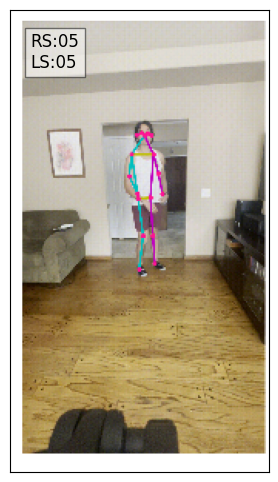

In [189]:
tracker = 0
total_RHRU_spins = 0
total_RHRD_spins = 0
# test_labels = np.array([0,0,3,2,1,0,3,2,1,0,1,2,3,0])
for i in range(1,len(numerical_labels)):
  assert numerical_labels[0]==0 #start facing the front
  difference = int(numerical_labels[i]-numerical_labels[i-1])
  if difference==0:
    pass
  elif difference in [1,-3]:
    tracker+=1
  else:
    tracker-=1
  if tracker==4:
    tracker=0
    total_RHRD_spins +=1
  elif tracker==-4:
    tracker=0
    total_RHRU_spins +=1
  fig, ax = plt.subplots(1,figsize=(4,6))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(output[i])
  ax.text(0.08, 0.95, f"RS:{total_RHRD_spins:02}\nLS:{total_RHRU_spins:02}", transform=ax.transAxes,
          fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
  plt.savefig(working_dir+f"output_movie/snapshots/movie_snapshot{i}.png")
  plt.close(fig)

In [190]:
images = []
for i in range(1,len(numerical_labels)):
  snapshot_path = working_dir+f"output_movie/snapshots/movie_snapshot{i}.png"
  images.append(imageio.imread(snapshot_path))

<ipython-input-190-45239344f397>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(snapshot_path))


In [197]:
imageio.mimsave(working_dir+f"output_movie/movie.gif", images,fps=10000)

drive/MyDrive/MoveNetProject/output_movie/snapshots/movie_snapshot299.png


In [103]:
total_CCW_spins, total_CW_spins

(2, 0)

In [98]:
numerical_labels[i-1]


0

In [93]:
[0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 0]

[0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 0]

In [74]:
qwer = np.array([0,1,2,3,0])
asdf = np.array([0,3,2,1,0])
np.diff(qwer), np.diff(asdf)

(array([ 1,  1,  1, -3]), array([ 3, -1, -1, -1]))

In [53]:
X = [None,None,None,None,None]
for i in range(20):
  X.append(i)
  X.pop(0)
X

[15, 16, 17, 18, 19]

In [49]:
array[np.concatenate(([True], array[1:] != array[:-1]))]

array(['front', 'right', 'back', 'left', 'front', 'left', 'back', 'right',
       'front', 'left', 'back', 'right', 'front', 'right', 'back', 'left',
       'front', 'right', 'back', 'left', 'front'], dtype='<U5')

In [ ]:
# array = np.array(dancer_orientations)
unique_categories = ["front","right","back","left"]#np.unique(dancer_orientations)
category_to_index = {orientation: index for index, orientation in enumerate(unique_categories)}
numerical_labels = np.array([category_to_index[orientation] for orientation in dancer_orientations])

# CCW_counts = 0
# CW_counts = 0
# counter = 0
# for i in range(len(numerical_labels)-1):
#   if numerical_labels[i] == numerical_labels[i+1]: #orientation unchanged
#     pass
#   elif numerical_labels[i] > numerical_labels[i+1]:

#   else:

# is_consecutive = np.concatenate(([True], array[1:] != array[:-1]))
# array[is_consecutive]
# # for i in range(len(dancer_orientations)):
# #   orientation
# np.diff(dancer_orientations)

In [ ]:
is_consecutive = np.concatenate(([True], numerical_labels[1:] != numerical_labels[:-1]))
numerical_labels[is_consecutive]

In [ ]:
rotation if 0,1,2,3 happens

In [ ]:
# to_gif(output,fps=5)
imageio.mimwrite('./animation.gif', output[:50],duration = 10)# duration=duration)

In [3]:
len(output)

NameError: name 'output' is not defined

In [11]:
# import cv2
# file_path = working_dir+"pose_calibration/IMG_3411.mov"
# cap = cv2.VideoCapture(file_path)
# if not cap.isOpened():
#     raise IOError("Error: Could not open video file.")

# frames = []
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break  # Exit loop when no more frames are available

#     # Convert BGR frame to RGB (if needed)
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     # Append the frame to the list
#     frames.append(frame_rgb)

# # Release the video capture object
# cap.release()

# # Release the video capture object
# cap.release()

# # Convert list of frames to a NumPy array (shape: [num_frames, height, width, channels])
# video_array = np.array(frames)

In [4]:
# video_array.shape

In [ ]:
video_tensor = tf.convert_to_tensor(video_array, dtype=tf.float32)
# image = tf.io.read_file(image_path)
# image = tf.image.decode_gif(image)
video_tensor